In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from cgpm2.finite_rowmix import FiniteRowMixture
from cgpm2.product import Product
from cgpm2.crp import CRP
from cgpm2.categorical import Categorical
from cgpm2.normal import Normal
from cgpm2.transition_hypers import transition_hypers
from cgpm2.transition_hypers import transtion_hyper_grids
from cgpm2.walks import get_cgpms_by_output_index
from cgpm2.transition_rows import transition_rows
from cgpm2.transition_crosscat import transition_cgpm_view_assigments

In [4]:
prng = np.random.RandomState(2)

### Basic univariate 3 component mixture 

In [5]:
data0 = prng.normal(loc=0, scale=2, size=20)
data1 = prng.normal(loc=30, scale=1, size=20)
data2 = prng.normal(loc=-30, scale=1, size=20)

In [6]:
data = np.concatenate((data0, data1, data2))

In [7]:
finite_mixture = FiniteRowMixture(
    cgpm_row_divide=Categorical([-1], [], distargs={'k':3}, rng=prng),
    cgpm_components=[Normal([0], [], rng=prng), Normal([0], [], rng=prng), Normal([0], [], rng=prng)],
    rng=prng)

In [8]:
for rowid, value in enumerate(data):
    finite_mixture.incorporate(rowid, {0: value})

In [9]:
grids = {
    0  : transtion_hyper_grids(get_cgpms_by_output_index(finite_mixture, 0), 30),
    -1 : transtion_hyper_grids(get_cgpms_by_output_index(finite_mixture, -1), 30)
}

In [10]:
cgpms = {
    0: get_cgpms_by_output_index(finite_mixture, 0),
    -1 : get_cgpms_by_output_index(finite_mixture, -1),
}

In [11]:
%%timeit -n1 -r1
for step in xrange(500):
    print '\r%d' % (step,),
    import sys; sys.stdout.flush()
    rowids = prng.permutation(range(len(data)))
    for rowid in rowids:
        transition_rows(finite_mixture, rowid, prng)
    for output in finite_mixture.outputs:
        transition_hypers(cgpms[output], grids[output], prng)

499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1 loop, best of 1: 14.2 s per loop



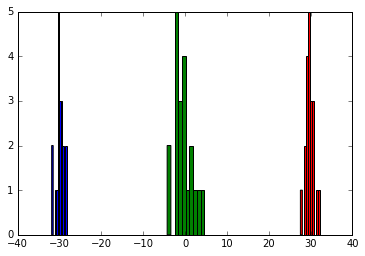

In [12]:
assignments = finite_mixture.cgpm_row_divide.data
counts = finite_mixture.cgpm_row_divide.counts
fig, ax = plt.subplots()
for cluster, _counts in enumerate(counts):
    rowids = [rowid for rowid, z in assignments.iteritems() if z == cluster]
    ax.hist(data[rowids])

### Basic bivariate 2 component mixture

In [13]:
finite_mixture = FiniteRowMixture(
    cgpm_row_divide=Categorical([-1], [], distargs={'k':2}, rng=prng),
    cgpm_components=[
        Product([Normal([0], [], rng=prng), Normal([1], [], rng=prng)]),
        Product([Normal([0], [], rng=prng), Normal([1], [], rng=prng)]),
    ],
    rng=prng)

In [14]:
df = pd.read_csv('resources/two_clusters.csv', index_col=False)

In [15]:
df.loc[0,'x'] = df.loc[50,'y'] = np.nan
df.loc[10,'x'] = df.loc[30,'y'] = np.nan
df.loc[33,'x'] = df.loc[33,'y'] = np.nan

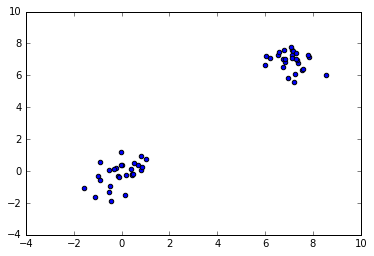

In [16]:
fig, ax = plt.subplots()
ax.scatter(df.x, df.y)

In [17]:
for rowid, row in df.iterrows():
    finite_mixture.incorporate(rowid, {0: row.x, 1: row.y})

In [18]:
grids = {
    -1 : transtion_hyper_grids(get_cgpms_by_output_index(finite_mixture, -1), 30),
    0  : transtion_hyper_grids(get_cgpms_by_output_index(finite_mixture, 0), 30),
    1  : transtion_hyper_grids(get_cgpms_by_output_index(finite_mixture, 1), 30),
}
cgpms = {
    -1 : get_cgpms_by_output_index(finite_mixture, -1),
    0: get_cgpms_by_output_index(finite_mixture, 0),
    1: get_cgpms_by_output_index(finite_mixture, 1),
}

In [19]:
%%timeit -n1 -r1
for step in xrange(500):
    print '\r%d' % (step,),
    import sys; sys.stdout.flush()
    rowids = prng.permutation(range(len(data)))
    for rowid in rowids:
        transition_rows(finite_mixture, rowid, prng)
    for output in finite_mixture.outputs:
        transition_hypers(cgpms[output], grids[output], prng)

499                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 1 loop, best of 1: 15.7 s per loop



In [20]:
assignments = finite_mixture.cgpm_row_divide.data
counts = finite_mixture.cgpm_row_divide.counts

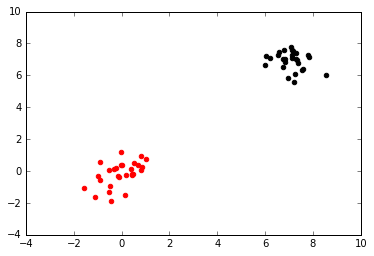

In [21]:
assignments = finite_mixture.cgpm_row_divide.data
counts = finite_mixture.cgpm_row_divide.counts
fig, ax = plt.subplots()
for cluster, color in enumerate(['r','k','g','y','b']):
    rowids = [rowid for rowid, z in assignments.iteritems() if z == cluster]
    ax.scatter(df.loc[rowids].x, df.loc[rowids].y, color=color)